# NN predicting a generated shuttlecock trajectory

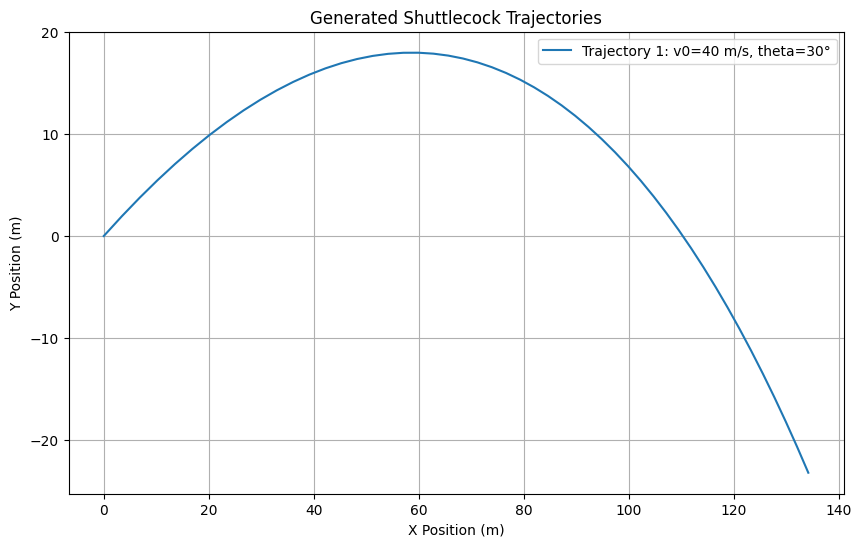

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Constants for trajectory simulation
g = 9.81  # Gravity (m/s^2)
b = 0.1  # Air resistance coefficient
time_step = 0.1  # Time step for simulation

class GenDataEquations:
    def __init__(self, v_initial=30, theta_initial=30):
        """
        Initialize the data generation equations for the shuttlecock trajectory.

        Parameters:
        v_initial (float): Initial velocity of the shuttlecock (m/s).
        theta_initial (float): Launch angle of the shuttlecock (degrees).
        """
        self.theta_initial = np.radians(theta_initial)
        self.v_x0 = v_initial * np.cos(self.theta_initial)
        self.v_y0 = v_initial * np.sin(self.theta_initial)

    def calculate_position(self, t):
        """
        Calculate the position (x, y) at time t.

        Parameters:
        t (float or np.ndarray): Time (s).

        Returns:
        tuple: (x, y) positions at time t.
        """
        x = (self.v_x0 / b) * (1 - np.exp(-b * t))
        y = (1 / b) * ((self.v_y0 + g / b) * (1 - np.exp(-b * t)) - (g * t))
        return x, y

    def generate_trajectory(self, total_time):
        """
        Generate the trajectory data over a specified total time.

        Parameters:
        total_time (float): Total simulation time (s).

        Returns:
        tuple: (t, x, y) arrays representing the trajectory.
        """
        t = np.arange(0, total_time, time_step)
        x, y = self.calculate_position(t)
        return t, x, y

# Generate multiple trajectories
conditions = [
    {"v_initial": 40, "theta_initial": 30},  # Valid because v_initial > 30 m/s for 30°
    # {"v_initial": 25, "theta_initial": 30},  # Valid
    # {"v_initial": 55, "theta_initial": 30},  # Valid because v_initial < 56 m/s
    # {"v_initial": 35, "theta_initial": 30},  # Valid because v_initial > 30 m/s for 30°
]

data = []
for condition in conditions:
    generator = GenDataEquations(v_initial=condition["v_initial"], theta_initial=condition["theta_initial"])
    t, x, y = generator.generate_trajectory(total_time=5)  # Fixed total time of 5 seconds
    data.append((t, x, y))

# Visualize all trajectories
plt.figure(figsize=(10, 6))
for i, (t, x, y) in enumerate(data):
    plt.plot(x, y, label=f"Trajectory {i+1}: v0={conditions[i]['v_initial']} m/s, theta={conditions[i]['theta_initial']}°")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Generated Shuttlecock Trajectories")
plt.grid()
plt.legend()
plt.show()

# Combine data for training
all_t = np.concatenate([t for t, _, _ in data])
all_x = np.concatenate([x for _, x, _ in data])
all_y = np.concatenate([y for _, _, y in data])

# Custom dataset class
class TrajectoryDataset(Dataset):
    def __init__(self, t, x, y):
        # Remove NaN entries
        valid_indices = ~np.isnan(x) & ~np.isnan(y)
        self.t = torch.tensor(t[valid_indices], dtype=torch.float32).unsqueeze(1)
        self.x = torch.tensor(x[valid_indices], dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y[valid_indices], dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.t)

    def __getitem__(self, idx):
        return self.t[idx], self.x[idx], self.y[idx]

# Create dataset and dataloader
dataset = TrajectoryDataset(all_t, all_x, all_y)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define the PiNN model
class PiNN(nn.Module):
    def __init__(self):
        super(PiNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 4)  # Output x, y, v_x, v_y 
        )

    def forward(self, t):
        return self.model(t)

# Initialize model, loss, and optimizer
model = PiNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, dataloader, criterion, optimizer, epochs=1000):
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for t_batch, x_batch, y_batch in dataloader:
            optimizer.zero_grad()
            predictions = model(t_batch)
            loss = criterion(predictions[:, 0], x_batch.squeeze()) + \
                   criterion(predictions[:, 1], y_batch.squeeze())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

In [61]:
import imageio

# Training loop with video frame saving
def train_model_with_video(model, dataloader, criterion, optimizer, epochs=1000, save_interval=50):
    frames = []  # To store file paths of saved images
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for t_batch, x_batch, y_batch in dataloader:
            optimizer.zero_grad()
            predictions = model(t_batch)
            loss = criterion(predictions[:, 0], x_batch.squeeze()) + \
                   criterion(predictions[:, 1], y_batch.squeeze())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Save a frame every save_interval epochs
        if (epoch + 1) % save_interval == 0:
            t_test = np.linspace(0, 5, 100)
            predictions = predict_trajectory(model, t_test)

            plt.figure(figsize=(10, 6))
            plt.plot(all_x, all_y, label="True Trajectories", marker="o")
            plt.plot(predictions[:, 0], predictions[:, 1], label=f"Predicted Trajectory (Epoch {epoch+1})", linestyle="--")
            plt.xlabel("X Position (m)")
            plt.ylabel("Y Position (m)")
            plt.title(f"Trajectory Prediction (Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f})")
            plt.grid()
            plt.legend()

            frame_path = f"frame_{epoch + 1:04d}.png"
            plt.savefig(frame_path)
            plt.close()
            frames.append(frame_path)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

    # Create video from saved frames
    video_path = "training_video.mp4"
    with imageio.get_writer(video_path, fps=2) as writer:
        for frame in frames:
            image = imageio.imread(frame)
            writer.append_data(image)

    print(f"Video saved as {video_path}")

# Train the model and generate video
train_model_with_video(model, dataloader, criterion, optimizer, epochs=1000)


Epoch 1/1000, Loss: 7136.0240
Epoch 2/1000, Loss: 7470.8931
Epoch 3/1000, Loss: 5747.8581
Epoch 4/1000, Loss: 5298.4877
Epoch 5/1000, Loss: 6366.5504
Epoch 6/1000, Loss: 6802.1724
Epoch 7/1000, Loss: 5794.7657
Epoch 8/1000, Loss: 6659.5471
Epoch 9/1000, Loss: 5730.6115
Epoch 10/1000, Loss: 5613.4276
Epoch 11/1000, Loss: 7648.7733
Epoch 12/1000, Loss: 4963.7460
Epoch 13/1000, Loss: 6365.8428
Epoch 14/1000, Loss: 5134.5190
Epoch 15/1000, Loss: 5529.8678
Epoch 16/1000, Loss: 5721.5461
Epoch 17/1000, Loss: 4869.7954
Epoch 18/1000, Loss: 3829.7304
Epoch 19/1000, Loss: 4607.8969
Epoch 20/1000, Loss: 4061.7048
Epoch 21/1000, Loss: 3874.1786
Epoch 22/1000, Loss: 2858.8518
Epoch 23/1000, Loss: 2768.1660
Epoch 24/1000, Loss: 2031.4096
Epoch 25/1000, Loss: 2190.0159
Epoch 26/1000, Loss: 1826.8967
Epoch 27/1000, Loss: 1779.8745
Epoch 28/1000, Loss: 1266.0290
Epoch 29/1000, Loss: 1102.8642
Epoch 30/1000, Loss: 1356.7441
Epoch 31/1000, Loss: 863.0759
Epoch 32/1000, Loss: 626.0886
Epoch 33/1000, Loss

C:\Users\THiNKBooK\AppData\Local\Temp\ipykernel_17036\1223056576.py:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 600) to (1008, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Epoch 1000/1000, Loss: 0.6448
Video saved as training_video.mp4


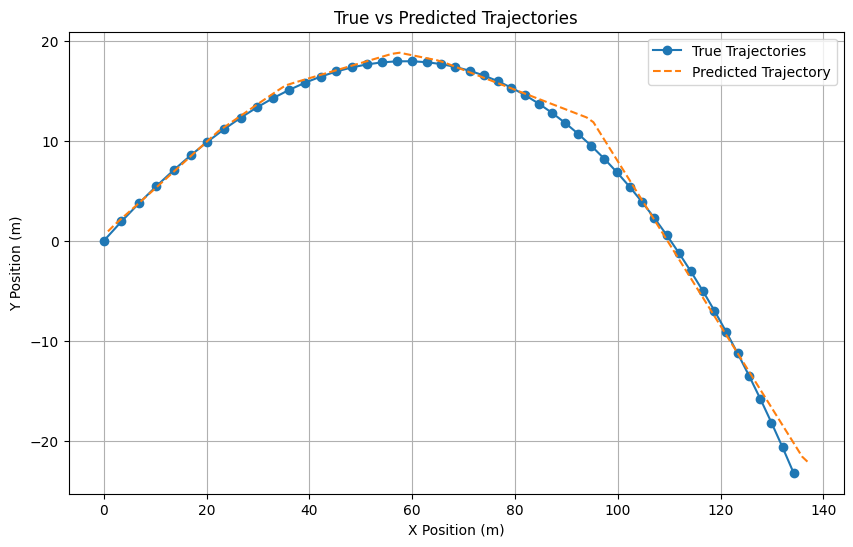

In [55]:
# Make predictions with the trained model
def predict_trajectory(model, t_values):
    model.eval()
    with torch.no_grad():
        t_tensor = torch.tensor(t_values, dtype=torch.float32).unsqueeze(1)
        predictions = model(t_tensor)
    return predictions.numpy()

# Generate new time values for prediction
t_test = np.linspace(0, 5, 100)
predictions = predict_trajectory(model, t_test)

# Visualize the predictions
plt.figure(figsize=(10, 6))
plt.plot(all_x, all_y, label="True Trajectories", marker="o")
plt.plot(predictions[:, 0], predictions[:, 1], label="Predicted Trajectory", linestyle="--")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("True vs Predicted Trajectories")
plt.grid()
plt.legend()
plt.show()

# PiNN precting shuttlecock trjectory

In [64]:
class PiNNWithPhysics(nn.Module):
    def __init__(self):
        super(PiNNWithPhysics, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Output x, y 
        )
    
    def forward(self, t):
        return self.model(t)

# Physics loss function based on the shuttlecock's motion
def physics_loss(t, x_pred, y_pred):
    # Compute the second derivatives (acceleration) using finite difference
    dt = t[1] - t[0]  # Assuming regular time steps
    x_ddot = (x_pred[2:] - 2*x_pred[1:-1] + x_pred[:-2]) / dt**2
    y_ddot = (y_pred[2:] - 2*y_pred[1:-1] + y_pred[:-2]) / dt**2
    
    # Compute the physics-based terms (based on Newton's second law with gravity and drag)
    # Example physics equation for shuttlecock: m * a = F = -b * v + m * g
    b = 0.1  # Air resistance coefficient
    g = 9.81  # Gravitational acceleration
    v_x = (x_pred[2:] - x_pred[:-2]) / (2 * dt)  # Velocity in x direction
    v_y = (y_pred[2:] - y_pred[:-2]) / (2 * dt)  # Velocity in y direction
    a_x_phys = -b * v_x  # Physics-based acceleration for x
    a_y_phys = -g - b * v_y  # Physics-based acceleration for y (gravity + drag)
    
    # Compute residuals for physics loss (how much the model deviates from the physical laws)
    residual_x = torch.abs(x_ddot - a_x_phys)
    residual_y = torch.abs(y_ddot - a_y_phys)
    
    # Return combined loss (average of x and y residuals)
    return torch.mean(residual_x) + torch.mean(residual_y)

# Correct the unpacking of model outputs in combined_loss function
def combined_loss(model, t, x_true, y_true, criterion):
    # Data-driven loss (MSE)
    predictions = model(t)
    x_pred, y_pred = predictions[:, 0], predictions[:, 1]  # Correct unpacking of predictions
    data_loss = criterion(x_pred, x_true) + criterion(y_pred, y_true)
    
    # Physics-based loss
    phys_loss = physics_loss(t, x_pred, y_pred)
    
    # Total loss: sum of data loss and physics loss
    total_loss = data_loss + phys_loss
    return total_loss


# Training loop with combined loss
def train_piNN_with_physics(model, dataloader, criterion, optimizer, epochs=1000, save_interval=50):
    frames = []  # To store file paths of saved images
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for t_batch, x_batch, y_batch in dataloader:
            optimizer.zero_grad()
            
            # Compute combined loss
            loss = combined_loss(model, t_batch, x_batch.squeeze(), y_batch.squeeze(), criterion)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        # Save a frame every save_interval epochs
        if (epoch + 1) % save_interval == 0:
            t_test = np.linspace(0, 5, 100)
            predictions = predict_trajectory(model, t_test)

            plt.figure(figsize=(10, 6))
            plt.plot(all_x, all_y, label="True Trajectories", marker="o")
            plt.plot(predictions[:, 0], predictions[:, 1], label=f"Predicted Trajectory (Epoch {epoch+1})", linestyle="--")
            plt.xlabel("X Position (m)")
            plt.ylabel("Y Position (m)")
            plt.title(f"Trajectory Prediction (Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f})")
            plt.grid()
            plt.legend()

            frame_path = f"frame_{epoch + 1:04d}.png"
            plt.savefig(frame_path)
            plt.close()
            frames.append(frame_path)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

    # Create video from saved frames
    video_path = "training_video_with_physics.mp4"
    with imageio.get_writer(video_path, fps=2) as writer:
        for frame in frames:
            image = imageio.imread(frame)
            writer.append_data(image)

    print(f"Video saved as {video_path}")

# Train the PiNN model with physics-based loss
train_piNN_with_physics(model, dataloader, criterion, optimizer, epochs=1000)


Epoch 1/1000, Loss: nan
Epoch 2/1000, Loss: nan
Epoch 3/1000, Loss: nan
Epoch 4/1000, Loss: nan
Epoch 5/1000, Loss: nan
Epoch 6/1000, Loss: nan
Epoch 7/1000, Loss: nan
Epoch 8/1000, Loss: nan
Epoch 9/1000, Loss: nan
Epoch 10/1000, Loss: nan
Epoch 11/1000, Loss: nan
Epoch 12/1000, Loss: nan
Epoch 13/1000, Loss: nan
Epoch 14/1000, Loss: nan
Epoch 15/1000, Loss: nan
Epoch 16/1000, Loss: nan
Epoch 17/1000, Loss: nan
Epoch 18/1000, Loss: nan
Epoch 19/1000, Loss: nan
Epoch 20/1000, Loss: nan
Epoch 21/1000, Loss: nan
Epoch 22/1000, Loss: nan
Epoch 23/1000, Loss: nan
Epoch 24/1000, Loss: nan
Epoch 25/1000, Loss: nan
Epoch 26/1000, Loss: nan
Epoch 27/1000, Loss: nan
Epoch 28/1000, Loss: nan
Epoch 29/1000, Loss: nan
Epoch 30/1000, Loss: nan
Epoch 31/1000, Loss: nan
Epoch 32/1000, Loss: nan
Epoch 33/1000, Loss: nan
Epoch 34/1000, Loss: nan
Epoch 35/1000, Loss: nan
Epoch 36/1000, Loss: nan
Epoch 37/1000, Loss: nan
Epoch 38/1000, Loss: nan
Epoch 39/1000, Loss: nan
Epoch 40/1000, Loss: nan
Epoch 41/

KeyboardInterrupt: 

# +

Epoch 1/100, Loss: 675.2275
Epoch 2/100, Loss: 703.9200
Epoch 3/100, Loss: 702.4180
Epoch 4/100, Loss: 709.9731
Epoch 5/100, Loss: 705.8301
Epoch 6/100, Loss: 665.0155
Epoch 7/100, Loss: 699.2005
Epoch 8/100, Loss: 654.8154
Epoch 9/100, Loss: 687.6396
Epoch 10/100, Loss: 664.1140
Epoch 11/100, Loss: 670.4551
Epoch 12/100, Loss: 682.2943
Epoch 13/100, Loss: 656.5297
Epoch 14/100, Loss: 679.2712
Epoch 15/100, Loss: 673.0347
Epoch 16/100, Loss: 682.3270
Epoch 17/100, Loss: 690.5226
Epoch 18/100, Loss: 650.7924
Epoch 19/100, Loss: 687.1082
Epoch 20/100, Loss: 684.7613
Epoch 21/100, Loss: 670.6342
Epoch 22/100, Loss: 676.3888
Epoch 23/100, Loss: 703.0435
Epoch 24/100, Loss: 658.3006
Epoch 25/100, Loss: 668.9515
Epoch 26/100, Loss: 697.7628
Epoch 27/100, Loss: 687.5639
Epoch 28/100, Loss: 664.5274
Epoch 29/100, Loss: 663.2293
Epoch 30/100, Loss: 698.6711
Epoch 31/100, Loss: 676.3867
Epoch 32/100, Loss: 678.5420
Epoch 33/100, Loss: 667.0423
Epoch 34/100, Loss: 663.2519
Epoch 35/100, Loss: 669

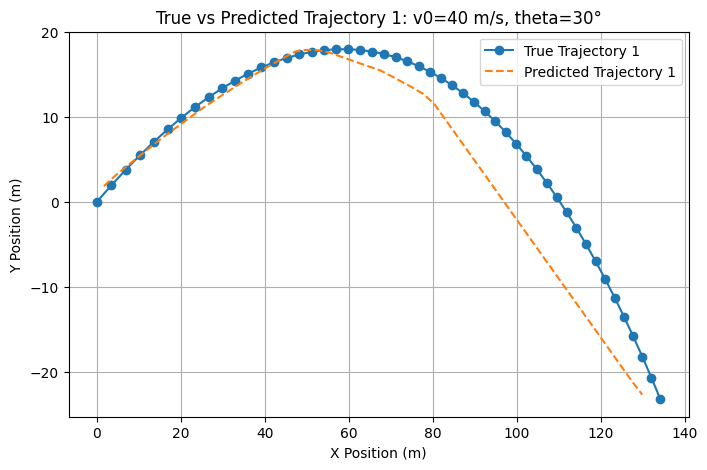

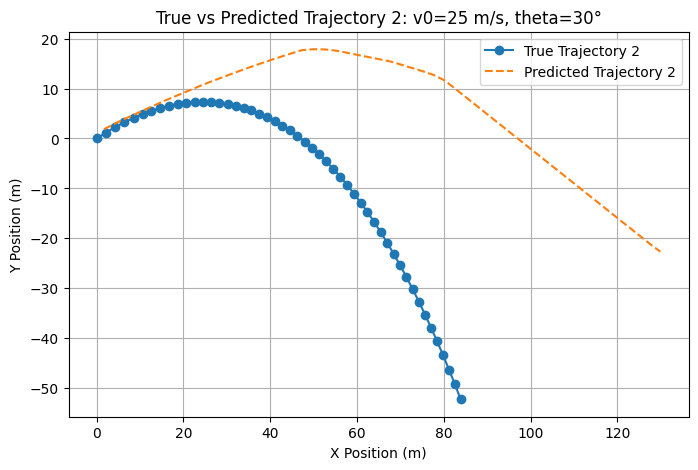

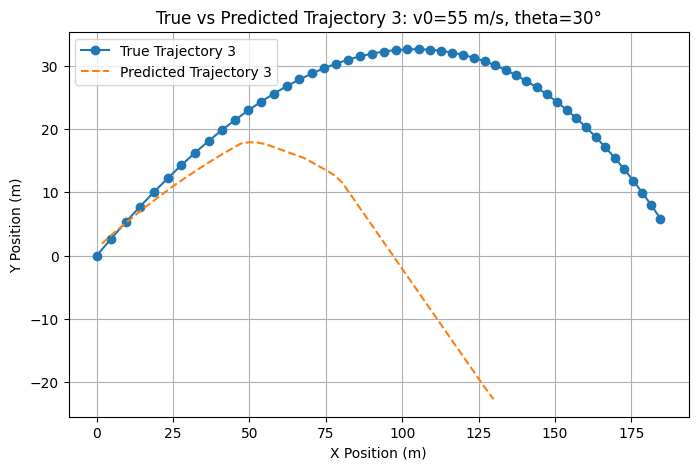

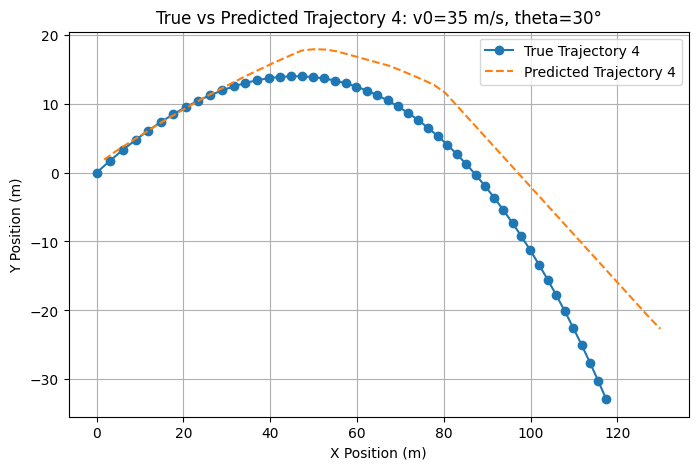

In [52]:

# Train the model
train_model(model, dataloader, criterion, optimizer)
# Make predictions for each example
for i, (t, x, y) in enumerate(data):
    # Generate predictions for the specific time values of this example
    predictions = predict_trajectory(model, t)

    # Visualize the ground truth and predicted trajectories
    plt.figure(figsize=(8, 5))
    plt.plot(x, y, label=f"True Trajectory {i+1}", marker="o")
    plt.plot(predictions[:, 0], predictions[:, 1], label=f"Predicted Trajectory {i+1}", linestyle="--")
    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.title(f"True vs Predicted Trajectory {i+1}: v0={conditions[i]['v_initial']} m/s, theta={conditions[i]['theta_initial']}°")
    plt.grid()
    plt.legend()
    plt.show()


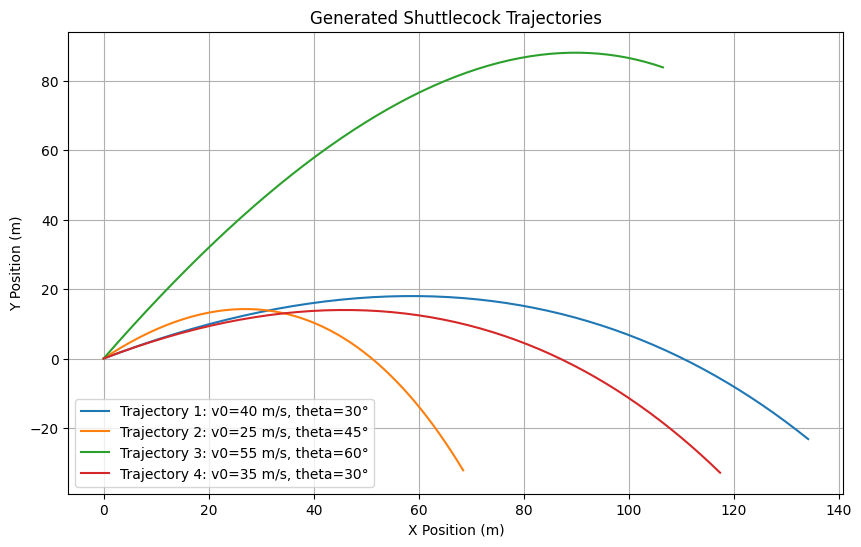

Epoch 1/100, Loss: 12722.9043
Epoch 2/100, Loss: 12256.3107
Epoch 3/100, Loss: 11832.0504
Epoch 4/100, Loss: 11308.2164
Epoch 5/100, Loss: 10223.2428
Epoch 6/100, Loss: 8934.2464
Epoch 7/100, Loss: 7659.1915
Epoch 8/100, Loss: 6510.8369
Epoch 9/100, Loss: 5505.9791
Epoch 10/100, Loss: 4978.4761
Epoch 11/100, Loss: 4584.9920
Epoch 12/100, Loss: 4425.2085
Epoch 13/100, Loss: 4250.3184
Epoch 14/100, Loss: 4138.4322
Epoch 15/100, Loss: 4023.0732
Epoch 16/100, Loss: 3969.9529
Epoch 17/100, Loss: 3872.3159
Epoch 18/100, Loss: 3766.2878
Epoch 19/100, Loss: 3673.9793
Epoch 20/100, Loss: 3502.9429
Epoch 21/100, Loss: 3439.4517
Epoch 22/100, Loss: 3272.8634
Epoch 23/100, Loss: 3160.1106
Epoch 24/100, Loss: 3074.0436
Epoch 25/100, Loss: 2969.3377
Epoch 26/100, Loss: 2839.8607
Epoch 27/100, Loss: 2724.4909
Epoch 28/100, Loss: 2679.7561
Epoch 29/100, Loss: 2587.9123
Epoch 30/100, Loss: 2437.3862
Epoch 31/100, Loss: 2319.0886
Epoch 32/100, Loss: 2189.8529
Epoch 33/100, Loss: 2099.5371
Epoch 34/100, 

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Constants for trajectory simulation
g = 9.81  # Gravity (m/s^2)
b = 0.1  # Air resistance coefficient
time_step = 0.1  # Time step for simulation

class GenDataEquations:
    def __init__(self, v_initial=30, theta_initial=30):
        """
        Initialize the data generation equations for the shuttlecock trajectory.

        Parameters:
        v_initial (float): Initial velocity of the shuttlecock (m/s).
        theta_initial (float): Launch angle of the shuttlecock (degrees).
        """
        self.theta_initial = np.radians(theta_initial)
        self.v_x0 = v_initial * np.cos(self.theta_initial)
        self.v_y0 = v_initial * np.sin(self.theta_initial)

    def calculate_position(self, t):
        """
        Calculate the position (x, y) at time t.

        Parameters:
        t (float or np.ndarray): Time (s).

        Returns:
        tuple: (x, y) positions at time t.
        """
        x = (self.v_x0 / b) * (1 - np.exp(-b * t))
        y = (1 / b) * ((self.v_y0 + g / b) * (1 - np.exp(-b * t)) - (g * t))
        return x, y

    def calculate_velocity(self, t):
        """
        Calculate the velocity (v_x, v_y) at time t.

        Parameters:
        t (float or np.ndarray): Time (s).

        Returns:
        tuple: (v_x, v_y) velocities at time t.
        """
        v_x = self.v_x0 * np.exp(-b * t)
        v_y = (self.v_y0 + g / b) * np.exp(-b * t) - g * t
        return v_x, v_y

    def generate_trajectory(self, total_time):
        """
        Generate the trajectory data over a specified total time.

        Parameters:
        total_time (float): Total simulation time (s).

        Returns:
        tuple: (t, x, y, v_x, v_y) arrays representing the trajectory and velocities.
        """
        t = np.arange(0, total_time, time_step)
        x, y = self.calculate_position(t)
        v_x, v_y = self.calculate_velocity(t)
        return t, x, y, v_x, v_y

# Generate multiple trajectories
conditions = [
    {"v_initial": 40, "theta_initial": 30},
    {"v_initial": 25, "theta_initial": 45},
    {"v_initial": 55, "theta_initial": 60},
    {"v_initial": 35, "theta_initial": 30},
]

data = []
for condition in conditions:
    generator = GenDataEquations(v_initial=condition["v_initial"], theta_initial=condition["theta_initial"])
    t, x, y, v_x, v_y = generator.generate_trajectory(total_time=5)  # Fixed total time of 5 seconds
    data.append((t, x, y, v_x, v_y))

# Visualize all trajectories
plt.figure(figsize=(10, 6))
for i, (t, x, y, _, _) in enumerate(data):
    plt.plot(x, y, label=f"Trajectory {i+1}: v0={conditions[i]['v_initial']} m/s, theta={conditions[i]['theta_initial']}°")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Generated Shuttlecock Trajectories")
plt.grid()
plt.legend()
plt.show()

# Combine data for training
all_t = np.concatenate([t for t, _, _, _, _ in data])
all_x = np.concatenate([x for _, x, _, _, _ in data])
all_y = np.concatenate([y for _, _, y, _, _ in data])
all_vx = np.concatenate([v_x for _, _, _, v_x, _ in data])
all_vy = np.concatenate([v_y for _, _, _, _, v_y in data])

# Custom dataset class
class TrajectoryDataset(Dataset):
    def __init__(self, t, x, y, vx, vy):
        valid_indices = ~np.isnan(x) & ~np.isnan(y) & ~np.isnan(vx) & ~np.isnan(vy)
        self.t = torch.tensor(t[valid_indices], dtype=torch.float32).unsqueeze(1)
        self.x = torch.tensor(x[valid_indices], dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y[valid_indices], dtype=torch.float32).unsqueeze(1)
        self.vx = torch.tensor(vx[valid_indices], dtype=torch.float32).unsqueeze(1)
        self.vy = torch.tensor(vy[valid_indices], dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.t)

    def __getitem__(self, idx):
        return self.t[idx], self.x[idx], self.y[idx], self.vx[idx], self.vy[idx]

# Create dataset and dataloader
dataset = TrajectoryDataset(all_t, all_x, all_y, all_vx, all_vy)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define the PiNN model
class PiNN(nn.Module):
    def __init__(self):
        super(PiNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 4)  # Output x, y, v_x, v_y
        )

    def forward(self, t):
        return self.model(t)

# Initialize model, loss, and optimizer
model = PiNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, dataloader, criterion, optimizer, epochs=100):
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for t_batch, x_batch, y_batch, vx_batch, vy_batch in dataloader:
            optimizer.zero_grad()
            predictions = model(t_batch)
            loss = criterion(predictions[:, 0], x_batch.squeeze()) + \
                   criterion(predictions[:, 1], y_batch.squeeze()) + \
                   criterion(predictions[:, 2], vx_batch.squeeze()) + \
                   criterion(predictions[:, 3], vy_batch.squeeze())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

# Train the model
train_model(model, dataloader, criterion, optimizer)


Epoch 1/100, Loss: 1261.2279
Epoch 2/100, Loss: 1250.1590
Epoch 3/100, Loss: 1271.2857
Epoch 4/100, Loss: 1262.4858
Epoch 5/100, Loss: 1255.6441
Epoch 6/100, Loss: 1273.8857
Epoch 7/100, Loss: 1249.9040
Epoch 8/100, Loss: 1324.3865
Epoch 9/100, Loss: 1279.1050
Epoch 10/100, Loss: 1265.8200
Epoch 11/100, Loss: 1296.7099
Epoch 12/100, Loss: 1316.1282
Epoch 13/100, Loss: 1298.8604
Epoch 14/100, Loss: 1275.9255
Epoch 15/100, Loss: 1277.9655
Epoch 16/100, Loss: 1285.1941
Epoch 17/100, Loss: 1271.9316
Epoch 18/100, Loss: 1299.7925
Epoch 19/100, Loss: 1285.9288
Epoch 20/100, Loss: 1275.8577
Epoch 21/100, Loss: 1298.5987
Epoch 22/100, Loss: 1286.0904
Epoch 23/100, Loss: 1256.2972
Epoch 24/100, Loss: 1245.0870
Epoch 25/100, Loss: 1287.4281
Epoch 26/100, Loss: 1290.5874
Epoch 27/100, Loss: 1277.4780
Epoch 28/100, Loss: 1293.7906
Epoch 29/100, Loss: 1259.7795
Epoch 30/100, Loss: 1276.5123
Epoch 31/100, Loss: 1255.5514
Epoch 32/100, Loss: 1247.8800
Epoch 33/100, Loss: 1305.4480
Epoch 34/100, Loss:

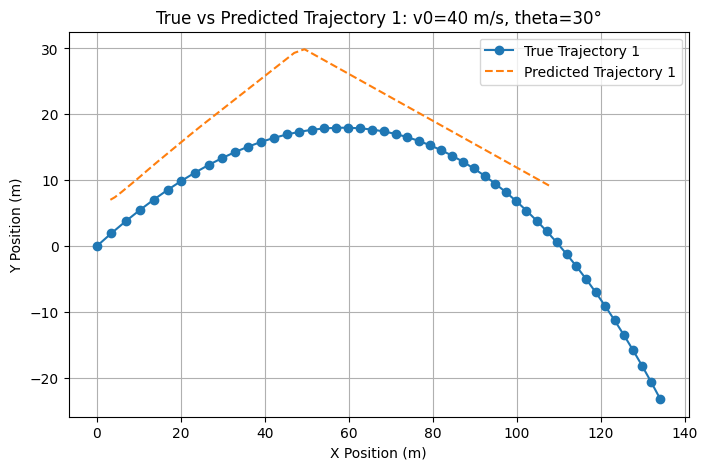

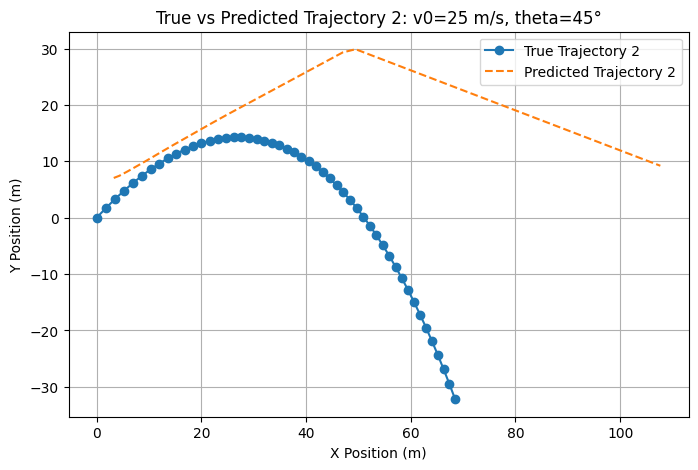

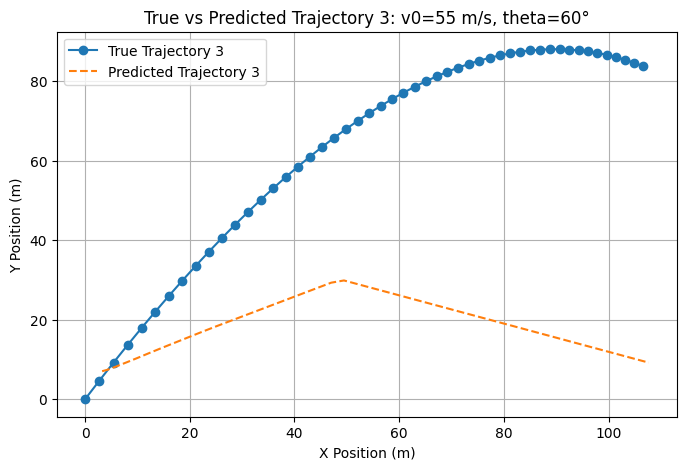

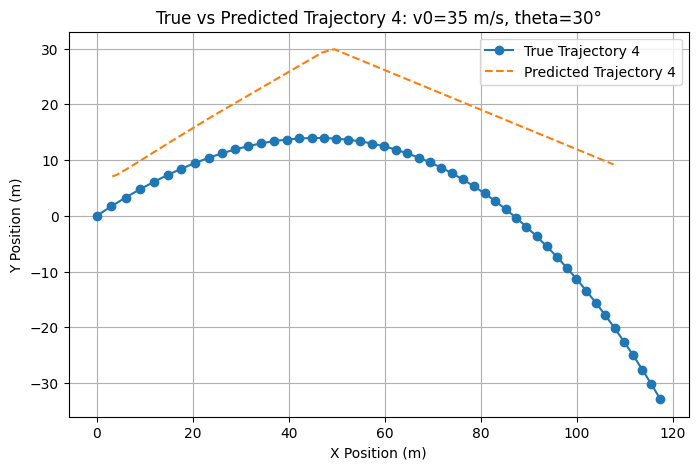

In [31]:
# Train the model
train_model(model, dataloader, criterion, optim.Adam(model.parameters(), lr=0.0001))
# Make predictions for each example
for i, (t,  x, y, _, _) in enumerate(data):
    # Generate predictions for the specific time values of this example
    predictions = predict_trajectory(model, t)

    # Visualize the ground truth and predicted trajectories
    plt.figure(figsize=(8, 5))
    plt.plot(x, y, label=f"True Trajectory {i+1}", marker="o")
    plt.plot(predictions[:, 0], predictions[:, 1], label=f"Predicted Trajectory {i+1}", linestyle="--")
    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.title(f"True vs Predicted Trajectory {i+1}: v0={conditions[i]['v_initial']} m/s, theta={conditions[i]['theta_initial']}°")
    plt.grid()
    plt.legend()
    plt.show()

In [25]:
data[0]

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
        3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]),
 array([  0.        ,   3.4468387 ,   6.85938078,  10.2379675 ,
         13.58293672,  16.89462294,  20.17335733,  23.41946777,
         26.63327887,  29.81511201,  32.96528539,  36.08411402,
         39.17190978,  42.22898146,  45.25563478,  48.25217238,
         51.21889395,  54.15609613,  57.06407267,  59.94311436,
         62.7935091 ,  65.61554195,  68.40949509,  71.17564794,
         73.91427711,  76.62565646,  79.31005714,  81.96774758,
         84.59899357,  87.20405821,  89.78320204,  92.33668295,
         94.8647563 ,  97.3676749 ,  99.84568904, 102.29904654,
        104.72799272, 107.13277047, 109.5136203 , 111.87078026,
        114.2044861 , 116.51497118, 118.80246654, 121.06720094,
        123.

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Define the PiNN model with the custom loss function
class PiNN(nn.Module):
    def __init__(self):
        super(PiNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 4)  # Output x, y, v_x, v_y
        )

    def forward(self, t):
        return self.model(t)
    
    def compute_ux(self,x_in):
        return torch.autograd.functional.jacobian(self, x_in, create_graph=True)

    def compute_loss(self, data, outputs, targets):
        # Data loss (Mean Squared Error between the predictions and targets)
        data_loss = torch.mean((outputs - targets) ** 2)
        
        # Physics loss
        phys_loss = 0.0
        g = 9.81  # Gravitational acceleration
        
        # Define a set of input time points for which we compute physics loss
        needed_domain = [torch.tensor([x], requires_grad=True) for x in [0.25, 2.0, 6.0, 8.0, 10.0]]
        
        for x_in in needed_domain:
            y_out = self.forward(x_in)

            # Compute the first derivative of outputs (u_x) with respect to input
            u_x = self.compute_ux(x_in)
            # Compute the second derivative (u_xx)
            u_xx = torch.autograd.functional.jacobian(self.compute_ux, x_in, create_graph=True)

            # Compute instantaneous speed and velocity components
            vx = y_out[2]  # Velocity in x direction
            vy = y_out[3]  # Velocity in y direction
            v = torch.sqrt(vx**2 + vy**2)  # Instantaneous speed

            # Drag coefficient
            C = 0.01  # You can adjust this based on your needs

            # Compute the x and y components of the drag force
            dx = C * v * vx
            dy = C * v * vy

            # Compute physics loss (using the derivatives and drag force)
            phys_loss += (u_xx[0] + dx) ** 2 + (u_xx[1] + g + dy) ** 2
        
        # Return the total loss (data loss + physics loss)
        phys_loss = torch.sqrt(phys_loss)
        return data_loss + phys_loss

# Custom dataset class to load data
class TrajectoryDataset(Dataset):
    def __init__(self, t, x, y, vx, vy):
        valid_indices = ~np.isnan(x) & ~np.isnan(y) & ~np.isnan(vx) & ~np.isnan(vy)
        self.t = torch.tensor(t[valid_indices], dtype=torch.float32).unsqueeze(1)
        self.x = torch.tensor(x[valid_indices], dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y[valid_indices], dtype=torch.float32).unsqueeze(1)
        self.vx = torch.tensor(vx[valid_indices], dtype=torch.float32).unsqueeze(1)
        self.vy = torch.tensor(vy[valid_indices], dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.t)

    def __getitem__(self, idx):
        return self.t[idx], self.x[idx], self.y[idx], self.vx[idx], self.vy[idx]

# Initialize model, loss, and optimizer
model = PiNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, dataloader, optimizer, epochs=100):
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for t_batch, x_batch, y_batch, vx_batch, vy_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(t_batch)
            targets = torch.cat([x_batch, y_batch, vx_batch, vy_batch], dim=1)  # Concatenate targets for x, y, vx, vy
            
            # Compute the custom loss
            loss = model.compute_loss(t_batch, outputs, targets)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

# Combine data for training (same as before)
all_t = np.concatenate([t for t, _, _, _, _ in data])
all_x = np.concatenate([x for _, x, _, _, _ in data])
all_y = np.concatenate([y for _, _, y, _, _ in data])
all_vx = np.concatenate([v_x for _, _, _, v_x, _ in data])
all_vy = np.concatenate([v_y for _, _, _, _, v_y in data])

# Create dataset and dataloader
dataset = TrajectoryDataset(all_t, all_x, all_y, all_vx, all_vy)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Train the model
train_model(model, dataloader, optimizer)


Epoch 1/100, Loss: 3182.4589
Epoch 2/100, Loss: 3069.6676
Epoch 3/100, Loss: 2916.1317
Epoch 4/100, Loss: 2763.1718
Epoch 5/100, Loss: 2538.8100
Epoch 6/100, Loss: 2237.1077
Epoch 7/100, Loss: 1978.4406
Epoch 8/100, Loss: 1785.8629
Epoch 9/100, Loss: 1626.6035
Epoch 10/100, Loss: 1499.8054
Epoch 11/100, Loss: 1437.1114
Epoch 12/100, Loss: 1355.0668
Epoch 13/100, Loss: 1339.3502
Epoch 14/100, Loss: 1279.6259
Epoch 15/100, Loss: 1255.3821
Epoch 16/100, Loss: 1194.9397
Epoch 17/100, Loss: 1156.5801
Epoch 18/100, Loss: 1084.7507
Epoch 19/100, Loss: 1035.5284
Epoch 20/100, Loss: 982.4178
Epoch 21/100, Loss: 912.5333
Epoch 22/100, Loss: 884.5009
Epoch 23/100, Loss: 813.5614
Epoch 24/100, Loss: 766.2623
Epoch 25/100, Loss: 729.9891
Epoch 26/100, Loss: 700.0982
Epoch 27/100, Loss: 658.1618
Epoch 28/100, Loss: 628.1651
Epoch 29/100, Loss: 599.9728
Epoch 30/100, Loss: 580.3601
Epoch 31/100, Loss: 570.5464
Epoch 32/100, Loss: 545.7849
Epoch 33/100, Loss: 541.9315
Epoch 34/100, Loss: 536.8735
Epoc

In [47]:
# Train the model
train_model(model, dataloader, optim.Adam(model.parameters(), lr=0.1))

Epoch 1/100, Loss: 885.8597
Epoch 2/100, Loss: 572.1120
Epoch 3/100, Loss: 567.8125
Epoch 4/100, Loss: 559.9917
Epoch 5/100, Loss: 583.0972
Epoch 6/100, Loss: 635.5709
Epoch 7/100, Loss: 569.3759


KeyboardInterrupt: 

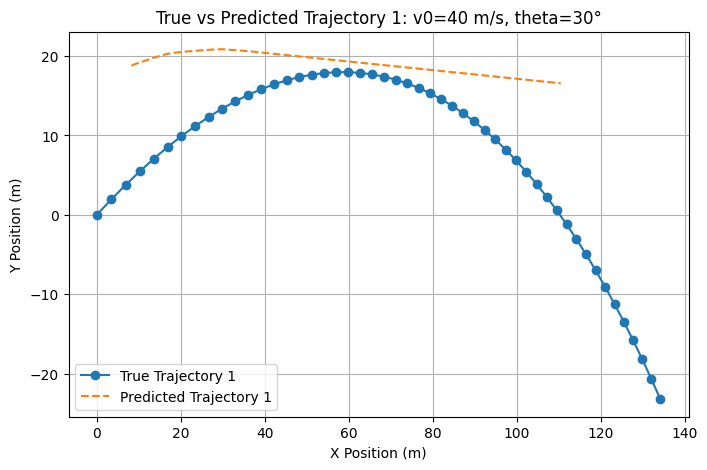

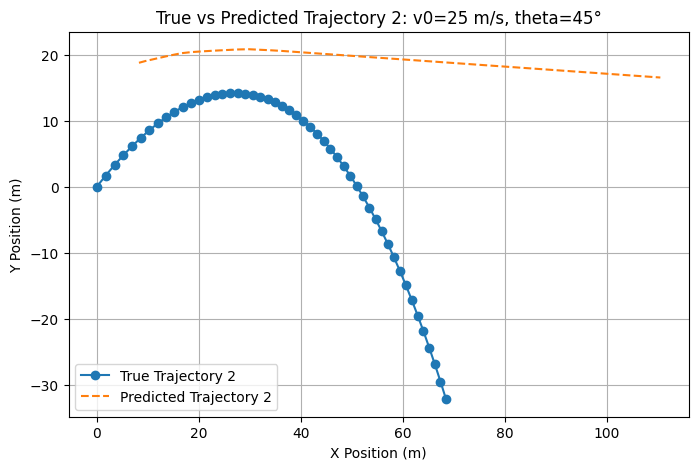

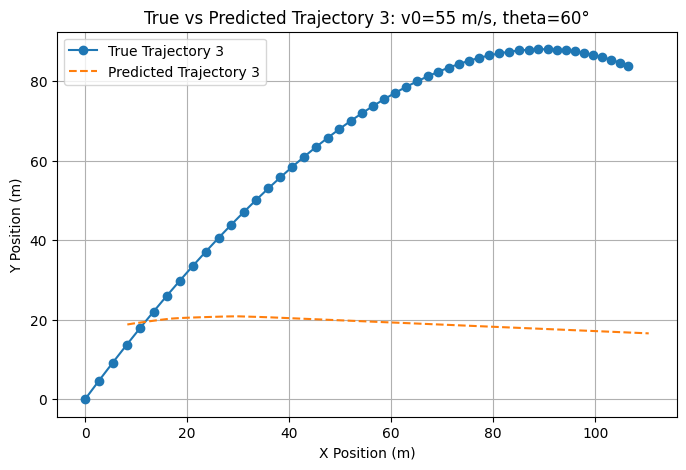

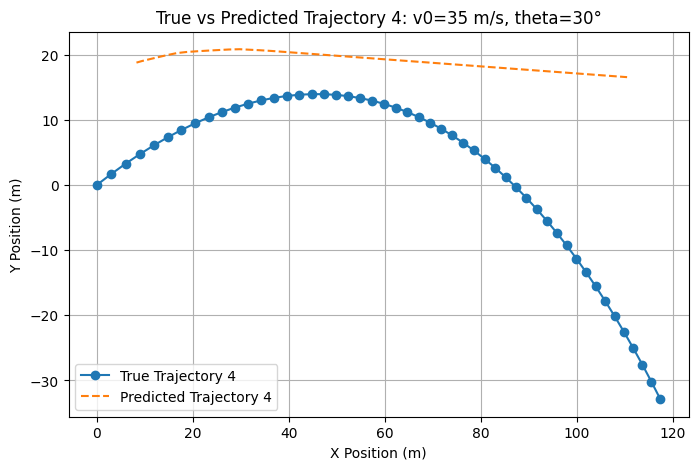

In [43]:
# Make predictions for each example
for i, (t,  x, y, _, _) in enumerate(data):
    # Generate predictions for the specific time values of this example
    predictions = predict_trajectory(model, t)

    # Visualize the ground truth and predicted trajectories
    plt.figure(figsize=(8, 5))
    plt.plot(x, y, label=f"True Trajectory {i+1}", marker="o")
    plt.plot(predictions[:, 0], predictions[:, 1], label=f"Predicted Trajectory {i+1}", linestyle="--")
    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.title(f"True vs Predicted Trajectory {i+1}: v0={conditions[i]['v_initial']} m/s, theta={conditions[i]['theta_initial']}°")
    plt.grid()
    plt.legend()
    plt.show()

FileNotFoundError: [WinError 2] The system cannot find the file specified

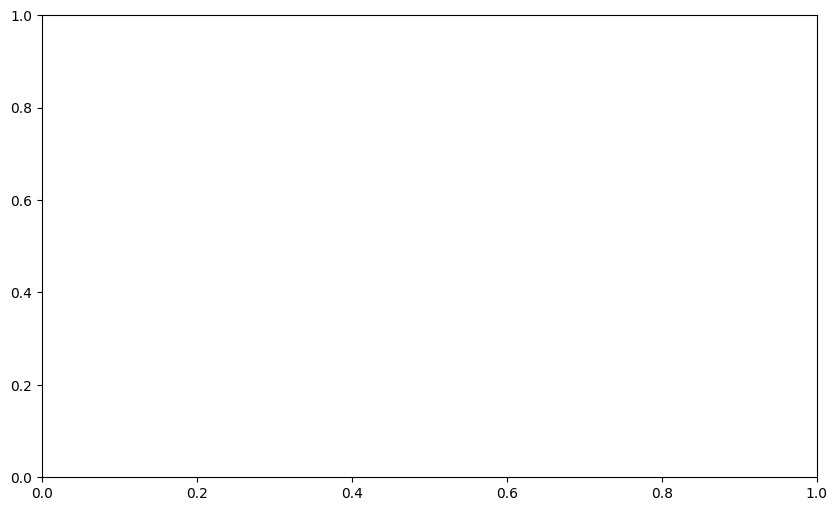

In [56]:
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter

# Adjusted train function to save plots for the video
def train_model_with_video(model, dataloader, criterion, optimizer, epochs=1000, interval=50):
    writer = FFMpegWriter(fps=2, metadata=dict(title="Training Progress", artist="Matplotlib"), bitrate=1800)
    fig, ax = plt.subplots(figsize=(10, 6))

    with writer.saving(fig, "training_progress.mp4", dpi=100):
        for epoch in range(epochs):
            model.train()
            total_loss = 0.0

            for t_batch, x_batch, y_batch in dataloader:
                optimizer.zero_grad()
                predictions = model(t_batch)
                loss = criterion(predictions[:, 0], x_batch.squeeze()) + \
                       criterion(predictions[:, 1], y_batch.squeeze())
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            # Save plot every `interval` epochs
            if (epoch + 1) % interval == 0 or epoch == epochs - 1:
                ax.clear()
                ax.set_title(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader):.4f}")
                ax.set_xlabel("X Position (m)")
                ax.set_ylabel("Y Position (m)")
                ax.grid()

                # Generate predictions for the entire trajectory
                model.eval()
                with torch.no_grad():
                    full_t = torch.linspace(0, 5, steps=100).unsqueeze(1)
                    predicted = model(full_t)
                    predicted_x = predicted[:, 0].numpy()
                    predicted_y = predicted[:, 1].numpy()

                # Plot true trajectories
                for i, (_, x, y) in enumerate(data):
                    ax.plot(x, y, label=f"True Trajectory {i+1}")

                # Plot predicted trajectory
                ax.plot(predicted_x, predicted_y, 'r--', label="Predicted Trajectory")

                ax.legend()
                writer.grab_frame()

            print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

# Call the training function with video output
train_model_with_video(model, dataloader, criterion, optimizer, epochs=1000)
